In [1]:
%matplotlib inline
#! switch_R 3.3
%load_ext rpy2.ipython

In [2]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import statsmodels.stats.api as sms
from pyspan import cross_validation as cv
from pyspan.ratings_task.analysis import *
from pyspan.config import *
from pyspan.valence import *
assert settings["mode"] == "crec"
INPUT_DIR = paths["input_dir"]
METRICS_DIR = paths["metrics_dir"]

/Users/sabinasloman/Box/LoP/pyspan/pyspan/config.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  

In [3]:
def calc_accuracy(i):
    polarity = signal_df.loc[partisan.loc[i]["word"]].rmetric > 0
    judgments = minidf[str(i)]
    judgments = judgments[~np.isnan(judgments)]
    return len(judgments[judgments > 2.5 if polarity else judgments < 2.5]), len(judgments)
v_calc_accuracy = np.vectorize(calc_accuracy)

In [4]:
p, n = v_calc_accuracy(p_ixs)
p = p / n
band_height = 1.96 * np.sqrt(p * (1 - p) / n)

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


/Users/sabinasloman/Box/LoP/pyspan/output/crec_debates_word_signals_accuracy


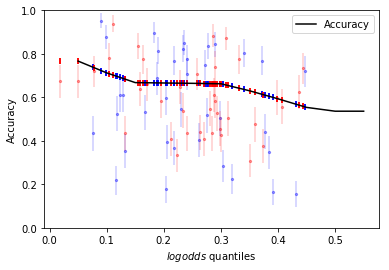

In [5]:
f, ax = cv.plot_("crec", "debates", "word", 
                 words = zip(partisan.loc[p_ixs]["word"].values, p, band_height))

Participant demographics

In [6]:
print len(minidf)
print np.mean(minidf.age[~np.isnan(minidf.age)]), stats.sem(minidf.age[~np.isnan(minidf.age)])
print len(minidf.loc[minidf.gender == "M"]), len(minidf.loc[minidf.gender == "F"])
print np.mean(minidf.voted)

147
37.65986394557823 0.8431946541195345
74 72
0.8163265306122449


Testing the difference in means

In [7]:
dat = minidf[map(str, p_ixs)].values
ddat = dat[:,partisan.loc[p_ixs].PKL_D > 0]
rdat = dat[:,partisan.loc[p_ixs].PKL_D < 0]

In [8]:
rmu = np.mean(rdat[~np.isnan(rdat)])
dmu = np.mean(ddat[~np.isnan(ddat)])
rsig = stats.sem(rdat[~np.isnan(rdat)])
dsig = stats.sem(ddat[~np.isnan(ddat)])

In [9]:
rmu, rsig, dmu, dsig

(2.8064862927790717,
 0.018095192583527254,
 2.2983811626195734,
 0.020143472287518626)

Analysis of variance

In [10]:
%%R -i ddat,rdat
# https://www.r-bloggers.com/how-to-do-repeated-measures-anovas-in-r/
y <- c(t(ddat), t(rdat))
n <- dim(ddat)[1]
stopifnot(n == dim(rdat)[1])
kd <- dim(ddat)[2]
kr <- dim(rdat)[2]
clusters <- c(rep(1:n, each = kd), rep(1:n, each = kr))
groups <- c(rep(0, n*kd), rep(1, n*kr))
fit <- aov(y ~ groups + Error(clusters/groups))
summary(fit)

library(lmerTest)
fit <- lmer(y ~ groups + (1|clusters))
anova(fit)

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lme4

  warnings.warn(x, RRuntimeWarning)
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘lmerTest’


  warnings.warn(x, RRuntimeWarning)
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:lme4’:

    lmer


  warnings.warn(x, RRuntimeWarning)
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is

Type III Analysis of Variance Table with Satterthwaite's method
       Sum Sq Mean Sq NumDF DenDF F value    Pr(>F)    
groups 710.95  710.95     1 10869  365.55 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Figure 3

In [11]:
perceps = PerceptualData(ixs = p_ixs)
perceps.get_discriminability_by_word()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     16.93
Date:                Thu, 30 Apr 2020   Prob (F-statistic):           0.000101
Time:                        15:35:13   Log-Likelihood:                -66.864
No. Observations:                  75   AIC:                             137.7
Df Residuals:                      73   BIC:                             142.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5470      0.069     36.859      0.0

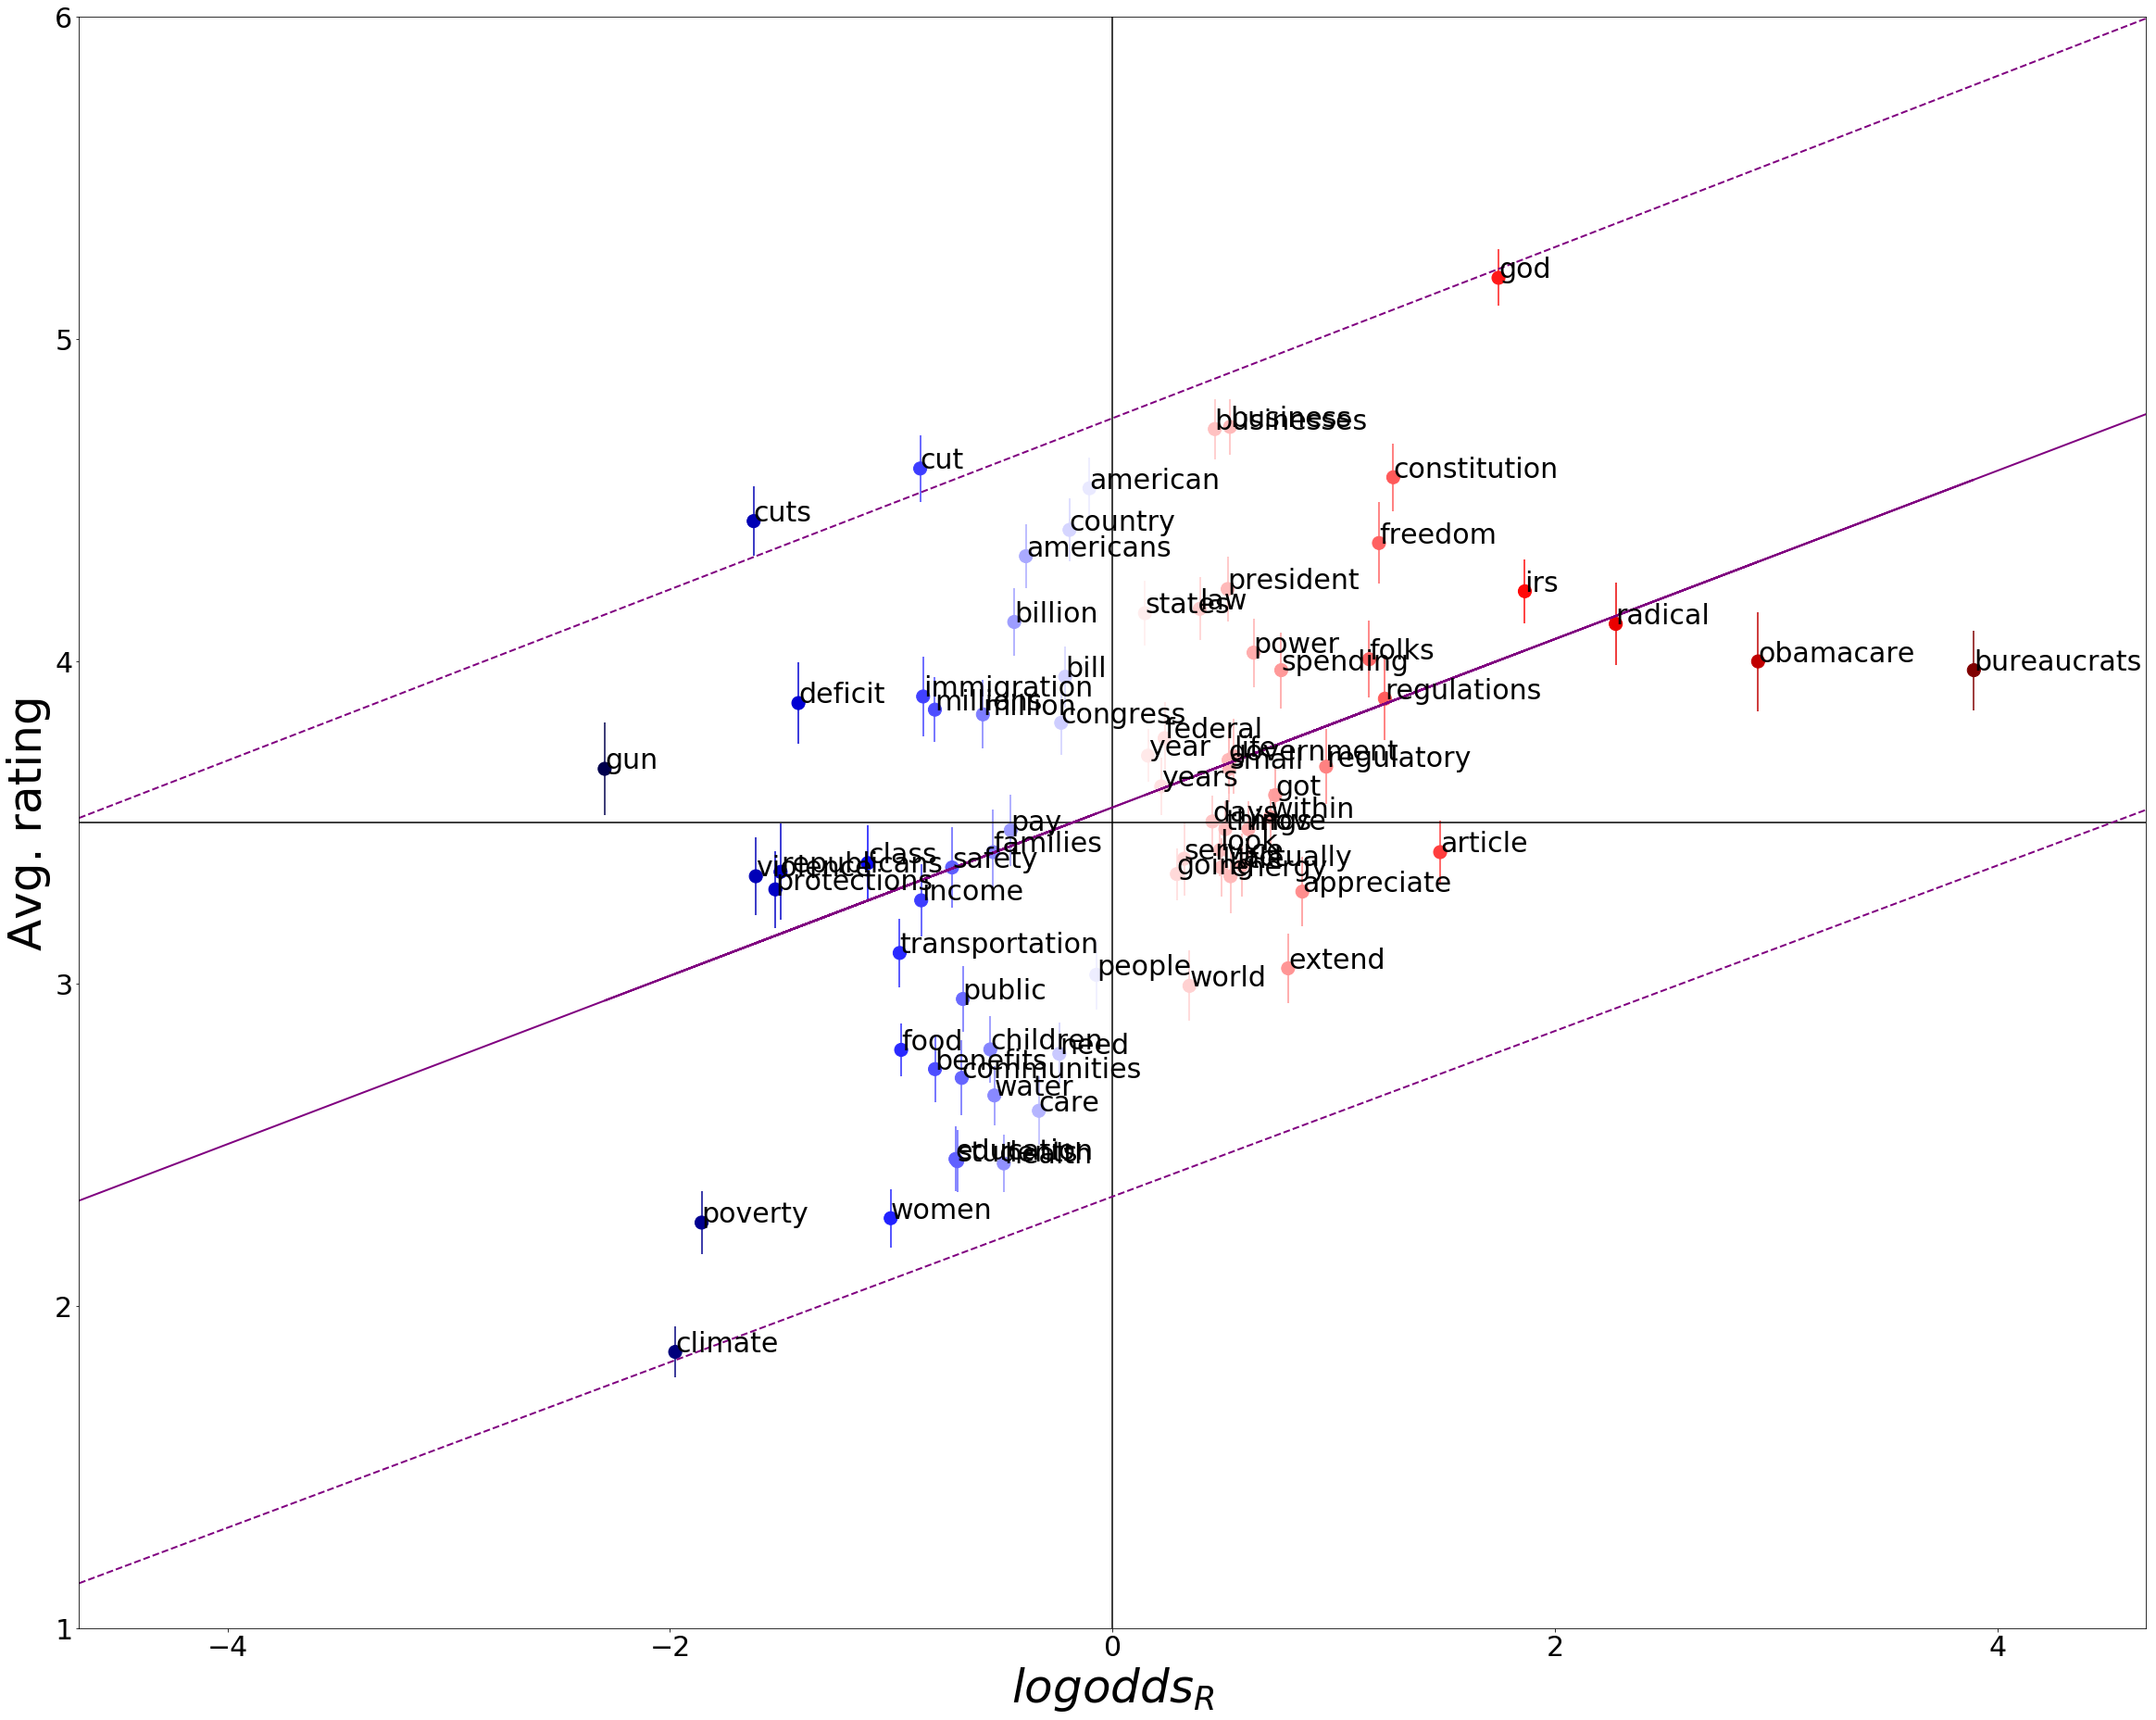

In [12]:
perceps.correlational_analysis(signal_df,
                               xlabel = r"$logodds_R$")

Compute an individual-level effect size and test the hypothesis that it's greater than 0.

In [13]:
signals = np.array(signals)
prop_right = []
for i in minidf.index:
    perceps = minidf.loc[i][map(str, p_ixs)].values
    perceps = np.array(list(map(float, perceps)))
    rjudgments = perceps[signals > 0]
    rjudgments = rjudgments[~np.isnan(rjudgments)]
    djudgments = perceps[signals < 0]
    djudgments = djudgments[~np.isnan(djudgments)]
    prop_right.append(cohensd(rjudgments, djudgments))

In [14]:
np.mean(prop_right), stats.sem(prop_right)

(0.4033623843300961, 0.02592686178162114)

In [15]:
t, p = stats.ttest_1samp(prop_right, 0)
t, p / 2

(15.557701804698516, 4.249474340581165e-33)

In [16]:
len(prop_right) - 1

146

Individual-level accuracies

In [17]:
signals = np.array(signals)
prop_right = []
for i in minidf.index:
    perceps = minidf.loc[i][map(str, p_ixs)].values
    perceps = np.array(list(map(float, perceps)))
    nright = len(perceps[((perceps < 2.5) & (signals < 0)) | ((perceps > 2.5) & (signals > 0))])
    prop_right.append(nright / len(perceps[~np.isnan(perceps)]))

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


In [18]:
np.mean(prop_right), stats.sem(prop_right)

(0.5861519836862302, 0.005877149218751656)

How many participants are doing better than chance?

In [19]:
len([ prop for prop in prop_right if prop > .5 ])

127

Testing for individual-level differences in discriminability between Democrats and Republicans

In [20]:
prop_right_r = []
for i in minidf.loc[minidf.party == "Republican"].index:
    perceps = minidf.loc[i][map(str, p_ixs)].values
    perceps = np.array(list(map(float, perceps)))
    rjudgments = perceps[signals > 0]
    rjudgments = rjudgments[~np.isnan(rjudgments)]
    djudgments = perceps[signals < 0]
    djudgments = djudgments[~np.isnan(djudgments)]
    prop_right_r.append(cohensd(rjudgments, djudgments))
    
prop_right_d = []
for i in minidf.loc[minidf.party == "Democrat"].index:
    perceps = minidf.loc[i][map(str, p_ixs)].values
    perceps = np.array(list(map(float, perceps)))
    rjudgments = perceps[signals > 0]
    rjudgments = rjudgments[~np.isnan(rjudgments)]
    djudgments = perceps[signals < 0]
    djudgments = djudgments[~np.isnan(djudgments)]
    prop_right_d.append(cohensd(rjudgments, djudgments))
    
prop_right_r = np.array(prop_right_r)
prop_right_d = np.array(prop_right_d)

In [21]:
cm = sms.CompareMeans(sms.DescrStatsW(prop_right_d), sms.DescrStatsW(prop_right_r))
cm.ttest_ind(usevar="unequal")

(3.4050653585985096, 0.0011332554083023421, 65.56602803605274)

Appendix: Analysis of hypothesized mediators

Logistic regression further investigating individual differences

Correct ~ logodds(word) + log(P(word)) + party(participant) + valence(word) + party(participant) $\times$ valence(word) $\times$ is\_republican(word) + party\_identity + party\_identity $\times$ party(participant) + political\_engagement + political\_engagement $\times$ party(participant) + $\ldots{}$

In [22]:
lr_data = minidf.copy()
lr_data = lr_data.loc[lr_data.party.isin([ "Democrat", "Republican" ])]
n = len(lr_data)
items = partisan.loc[p_ixs].word
n_vars = 9

# Add dummy columns
for i in range(1, n):
    ids = np.zeros(n)
    ids[i] = 1
    lr_data["participant{}".format(i)] = ids
    
Y_full = np.ravel(lr_data[map(str, p_ixs)])
Y = Y_full > 2.5
X = np.full((n * len(p_ixs), n_vars + n - 1), np.nan)
# The log odds that the word was said by a Republican
vf = np.vectorize(lambda word: abs(signal_df.loc[word]["rmetric"]))
X[:,0] = np.tile(vf(items), n)
# The log probability of hearing the word
vf = np.vectorize(lambda word: math.log(sum(freq_df.loc[(word,["dmetric","rmetric"])].values) / n_utterances, 2))
X[:,1] = np.tile(vf(items), n)
# Participant's political identity
vf = np.vectorize(lambda pid: 1 if pid == "Republican" else -1 if pid == "Democrat" else 0)
pids = np.repeat(vf(lr_data.party), len(p_ixs))
X[:,2] = pids
# Valence of word
vf = np.vectorize(lambda word: get_valence(word)[0]-5)
X[:,3] = np.tile(vf(items), n)
# Valence of word * Participant's party identity * Word is Republican
vf = np.vectorize(lambda word: signal_df.loc[word]["rmetric"])
v = np.tile(vf(items), n)
X[:,4] = pids * X[:,3] * np.sign(v) 
# Party identity
X[:,5] = np.repeat(lr_data.party_identity, len(p_ixs))
# Party affiliation x party identity
X[:,6] = pids * X[:,5]
# Political engagement
X[:,7] = np.repeat(lr_data.political_engagement, len(p_ixs))
# Party affiliation x political engagement
X[:,8] = pids * X[:,7]
# Participant IDs
for i in range(n_vars, n_vars + n - 1):
    X[:,i] = np.repeat(lr_data["participant{}".format(i-n_vars+1)], len(p_ixs))

vf = np.vectorize(lambda word: signal_df.loc[word]["rmetric"] > 0)
polarity = vf(items)
polarity = np.tile(polarity, n)
Y = (Y & polarity) | (~Y & ~polarity)

Y = Y[~np.isnan(Y_full)]
X = X[~np.isnan(Y_full)]
Y_full = Y_full[~np.isnan(Y_full)]
X = X[~np.isnan(Y)]
Y_full = Y_full[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]
Y = Y[~np.isnan(X).any(axis = 1)]
Y_full = Y_full[~np.isnan(X).any(axis = 1)]
X = X[~np.isnan(X).any(axis = 1),:]
X = stats.mstats.zscore(X)

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


In [23]:
logit = SparseLR(Y, X); logit.coef[:n_vars]

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.02841839, 0.        , 0.        , 0.        , 0.20008666,
       0.        , 0.        , 0.        , 0.        ])

In [24]:
logit.n, logit.auc

(6726, 0.5968726299406344)

How many items are effectively excluded on the basis of missing valence data?

In [25]:
vf = np.vectorize(lambda word: get_valence(word)[0]-5)
v = vf(items)
len(v[np.isnan(v)])

7